In [ ]:
# Call Api
!pip install wbgapi # here we are installing the official python interdace for this data
import wbgapi as wb #api calls
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# making sure all columns are shown later when previewing
pd.set_option('display.max_columns', None)

# Use a consistent 20-year window
START_YEAR = 2004
END_YEAR = 2023
YEARS = range(START_YEAR, END_YEAR + 1)

In [ ]:
#Getting the metadata

# Loading all the economies
#skippaggs=false to show regions like Europe and central asia etcetera
economies_meta = wb.economy.DataFrame(skipAggs=False).reset_index()

# Ensure we have a standard 'economy' column for country code
economies_meta = economies_meta.rename(columns={
    'index': 'economy',
    'id': 'economy'   # in case the column is named 'id' instead
})

# Flatten region and incomeLevel because this api makes the regions come out as a dictionary
for col in ['region', 'incomeLevel']:
    if col in economies_meta.columns:
        economies_meta[col] = economies_meta[col].apply(
            lambda x: x.get('value') if isinstance(x, dict) else x
        )

# Keep only the columns we need
economies_meta = economies_meta[['economy', 'name', 'region', 'incomeLevel']]

print("Economy metadata shape:", economies_meta.shape)
economies_meta.head()

Economy metadata shape: (266, 4)


,economy,name,region,incomeLevel
0,ABW,Aruba,LCN,HIC
1,AFE,Africa Eastern and Southern,,
2,AFG,Afghanistan,MEA,LIC
3,AFW,Africa Western and Central,,
4,AGO,Angola,SSF,LMC


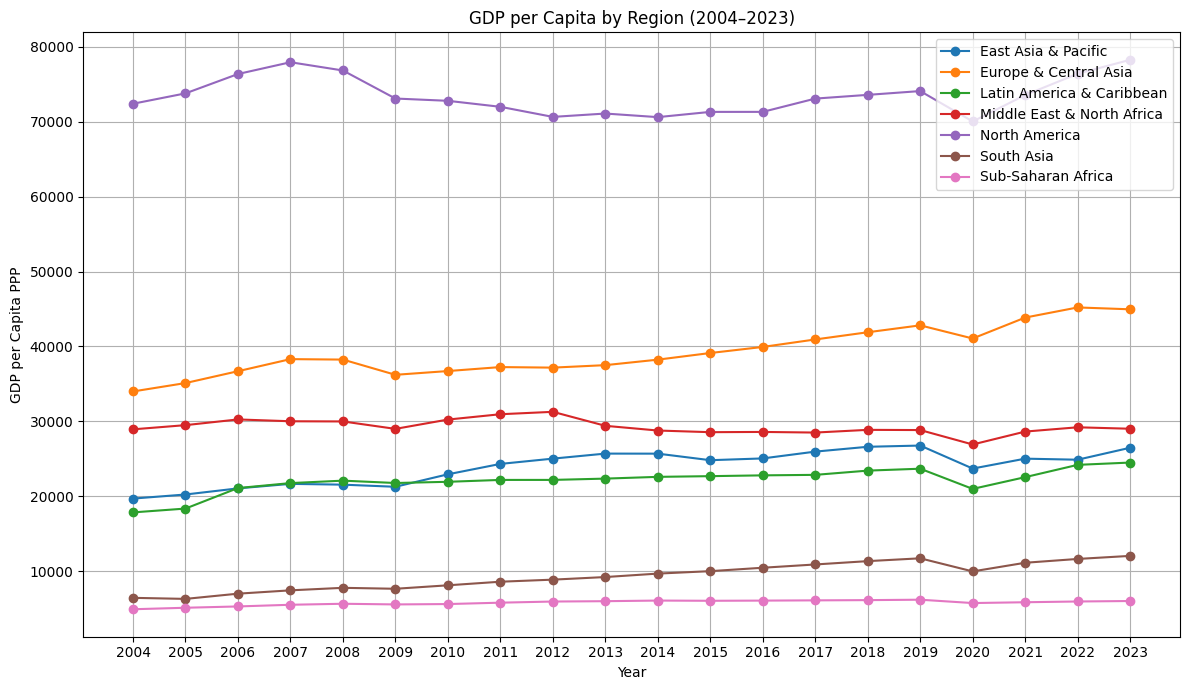

In [ ]:
#  Q1: GDP per Capita (PPP) by Region (2004–2023)
# -----------------------------------------------

GDPPC_IND = "NY.GDP.PCAP.PP.KD"  # GDP per capita, PPP (constant international $)

# Fetch GDP per capita PPP for all countries
gdp_pc = wb.data.DataFrame(
    [GDPPC_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,
    skipBlanks=True,   # drop rows with no data
    columns="series"
).reset_index()

# Merge GDP data with region metadata (adds name, region, incomeLevel)
gdp_pc = gdp_pc.merge(economies_meta, on="economy", how="left")

# Map region codes to full region names so that we see the name and not the code
region_map = {
    "EAS": "East Asia & Pacific",
    "ECS": "Europe & Central Asia",
    "LCN": "Latin America & Caribbean",
    "MEA": "Middle East & North Africa",
    "NAC": "North America",
    "SAS": "South Asia",
    "SSF": "Sub-Saharan Africa"
}

# Create a region_full column with the full names
gdp_pc["region_full"] = gdp_pc["region"].map(region_map).fillna(gdp_pc["region"])

# Clean: drop rows missing region name or GDP value
gdp_clean = gdp_pc.dropna(subset=["region_full", GDPPC_IND])

# Region-year summary: average GDP per capita PPP by region and year
gdp_region_year = (
    gdp_clean
    .groupby(["region_full", "Time"])[GDPPC_IND]
    .mean()
    .reset_index()
    .rename(columns={
        "region_full": "region_name",
        GDPPC_IND: "gdp_pc_ppp"
    })
)

# Plot GDP per Capita by Region
plt.figure(figsize=(12, 7))

for region in sorted(gdp_region_year["region_name"].unique()):
    sub = gdp_region_year[gdp_region_year["region_name"] == region]
    plt.plot(
        sub["Time"],
        sub["gdp_pc_ppp"],
        marker="o",
        label=region  # full region name
    )

plt.title("GDP per Capita by Region (2004–2023)")
plt.xlabel("Year")
plt.ylabel("GDP per Capita PPP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 fastest-growing economies:
                      Country region  avg_gdp_growth
77                     Guyana    LCN       10.797164
58                   Ethiopia    SSF        9.433859
182              Turkmenistan    ECS        8.633360
177  Turks and Caicos Islands    LCN        8.579236
35                      China    EAS        8.178589
155                     Qatar    MEA        8.038002
113          Macao SAR, China    EAS        7.404282
158                    Rwanda    SSF        7.326125
181                Tajikistan    ECS        7.210965
98                   Cambodia    EAS        7.054887

Bottom 10 slowest/declining economies:
                      Country region  avg_gdp_growth
127  Northern Mariana Islands    EAS       -2.048633
176      Syrian Arab Republic    MEA       -1.434610
201               Yemen, Rep.    MEA       -1.072447
160                     Sudan    SSF       -1.013742
196     Virgin Islands (U.S.)    LCN       -0.821098
8              American S

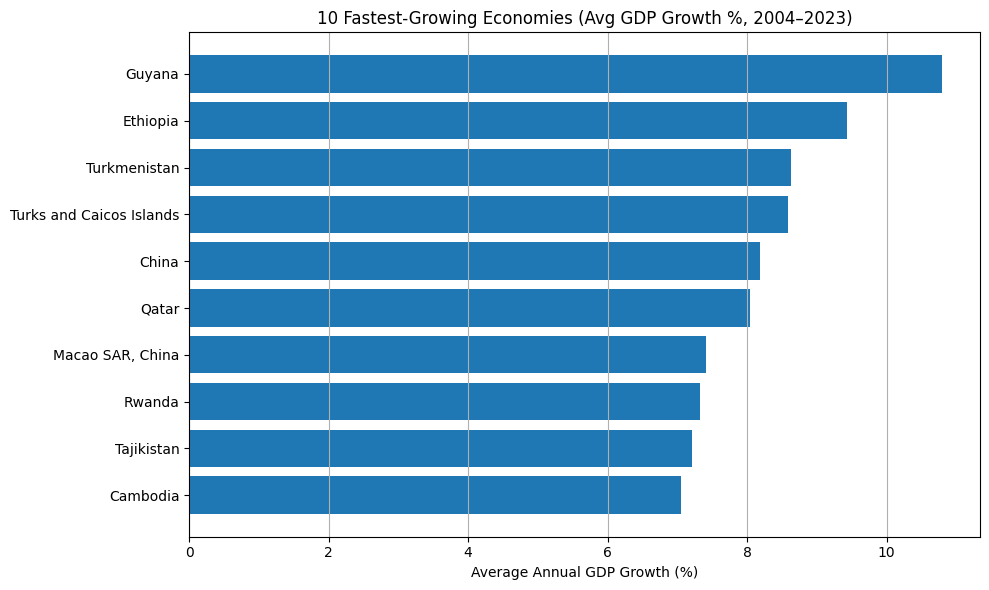

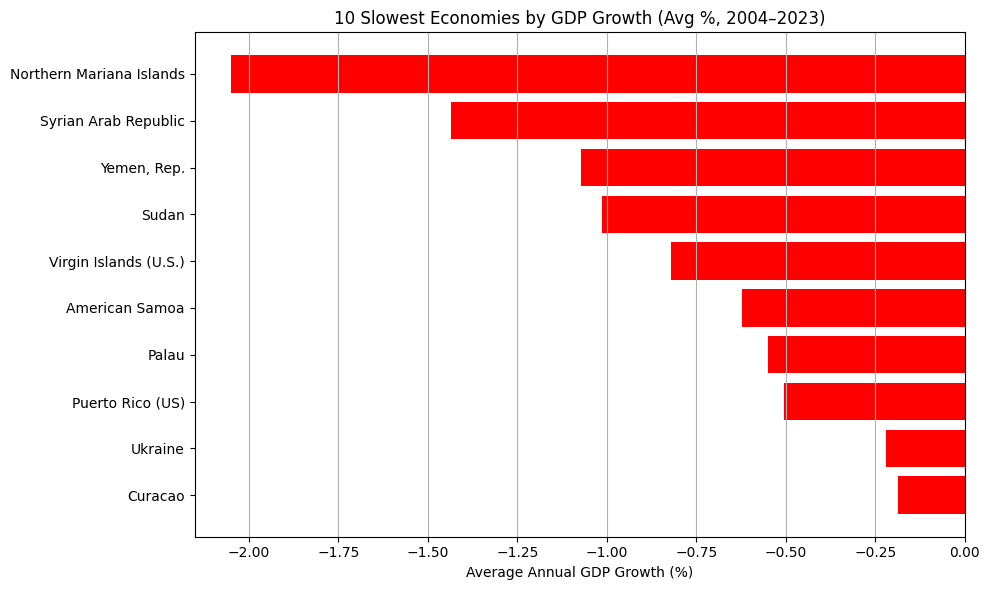

In [ ]:
# Q2: Fastest-Growing Economies (GDP growth %, 2004–2023)
# ---------------------------------------------------------

GDP_GROWTH_IND = "NY.GDP.MKTP.KD.ZG"  # GDP (annual % growth, constant prices)

# Pull GDP growth data for all countries
gdp_growth = wb.data.DataFrame(
    [GDP_GROWTH_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,    # only country-level no regions like central asia
    skipBlanks=True,  # drop rows with no data
    columns="series"
).reset_index()

# Keep only rows with valid growth values
gdp_growth = gdp_growth.dropna(subset=[GDP_GROWTH_IND])

# Add region information
gdp_growth = gdp_growth.merge(economies_meta[["economy", "region"]], on="economy", how="left")

# only keep countries with at least 15 years of data so that the chart is consistent
years_per_country = gdp_growth.groupby("economy")["Time"].nunique()
valid_economies = years_per_country[years_per_country >= 15].index
gdp_growth_valid = gdp_growth[gdp_growth["economy"].isin(valid_economies)]

# Average GDP growth by country over the period
growth_summary = (
    gdp_growth_valid
    .groupby(["economy", "Country", "region"])[GDP_GROWTH_IND]
    .mean()
    .reset_index()
    .rename(columns={GDP_GROWTH_IND: "avg_gdp_growth"})
)

# Getting the lists by sorting and then accessing Top 10 and bottom 10 economies
top10 = growth_summary.sort_values("avg_gdp_growth", ascending=False).head(10)
bottom10 = growth_summary.sort_values("avg_gdp_growth", ascending=True).head(10)

print("Top 10 fastest-growing economies:")
print(top10[["Country", "region", "avg_gdp_growth"]])

print("\nBottom 10 slowest/declining economies:")
print(bottom10[["Country", "region", "avg_gdp_growth"]])

# Top 10 bar plot
plt.figure(figsize=(10, 6))
plt.barh(top10["Country"], top10["avg_gdp_growth"])
plt.title("10 Fastest-Growing Economies (Avg GDP Growth %, 2004–2023)")
plt.xlabel("Average Annual GDP Growth (%)")
plt.gca().invert_yaxis()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

# Bottom 10 bar plot
plt.figure(figsize=(10, 6))
plt.barh(bottom10["Country"], bottom10["avg_gdp_growth"], color="red")
plt.title("10 Slowest Economies by GDP Growth (Avg %, 2004–2023)")
plt.xlabel("Average Annual GDP Growth (%)")
plt.gca().invert_yaxis()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

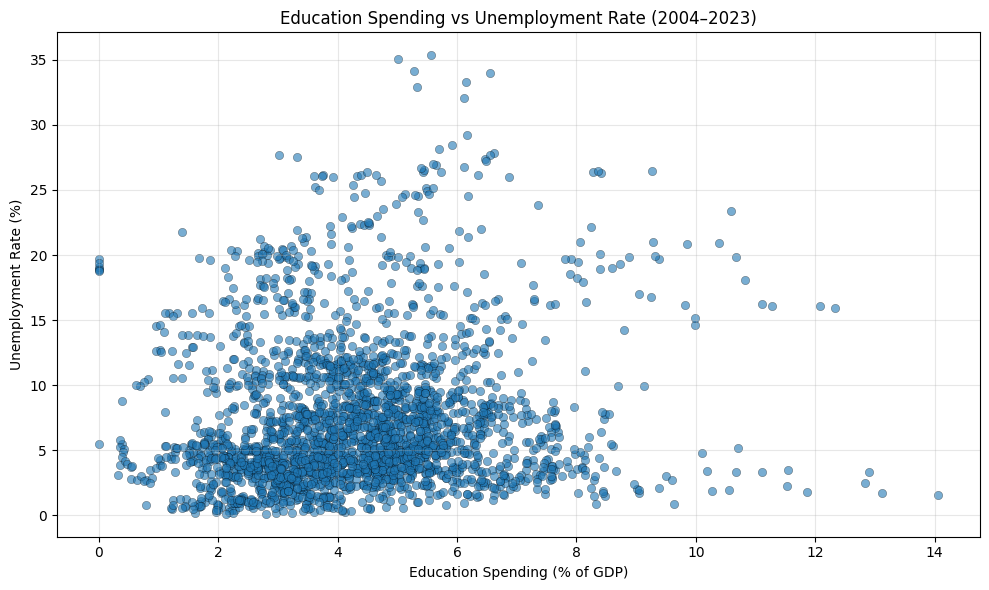

In [ ]:
# Q3: Education Spending vs Unemployment Rate
# --------------------------------------------

EDU_IND = "SE.XPD.TOTL.GD.ZS"   # Education spending (% of GDP)
UNEMP_IND = "SL.UEM.TOTL.ZS"    # Unemployment rate (%)

#Pull Education Spending data
edu_df = wb.data.DataFrame(
    [EDU_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,
    skipBlanks=True,
    columns="series"
).reset_index()

#Pull Unemployment Rate data
unemp_df = wb.data.DataFrame(
    [UNEMP_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,
    skipBlanks=True,
    columns="series"
).reset_index()

#Merge both datasets by country and year and then renaming columns we'll use
q3_df = edu_df.merge(
    unemp_df[["economy", "Time", UNEMP_IND]],
    on=["economy", "Time"],
    how="inner"
)
q3_df = q3_df.rename(columns={
    EDU_IND: "edu_spend",
    UNEMP_IND: "unemployment_rate",
    "Time": "year"
})

# Drop rows with missing values
q3_df = q3_df.dropna(subset=["edu_spend", "unemployment_rate"])

#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    q3_df["edu_spend"],
    q3_df["unemployment_rate"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

plt.title("Education Spending vs Unemployment Rate (2004–2023)")
plt.xlabel("Education Spending (% of GDP)")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

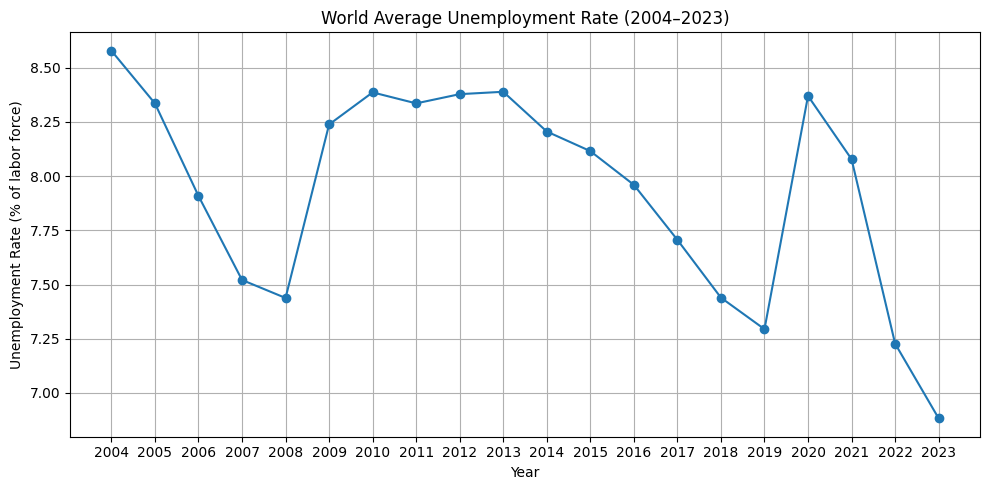

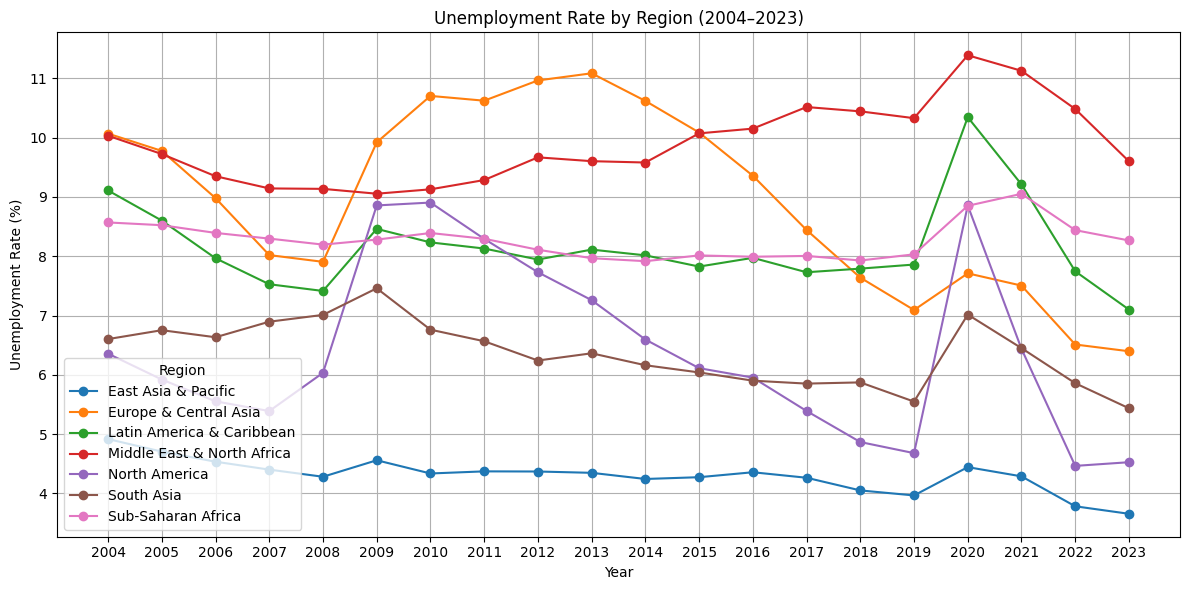

In [ ]:
# Q4: Global & Regional Unemployment Trends (2004–2023)
# -------------------------------------------------------

UNEMP_IND = "SL.UEM.TOTL.ZS"  # Unemployment rate (% of labor force)

#Pull unemployment data for all countries
unemp = wb.data.DataFrame(
    [UNEMP_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,    # country-level only
    skipBlanks=True,
    columns="series"
).reset_index()

# Add region metadata
unemp = unemp.merge(
    economies_meta[["economy", "region"]],
    on="economy",
    how="left"
)
# Map region codes to full region names (fallback to original if already full name)
region_map = {
    "EAS": "East Asia & Pacific",
    "ECS": "Europe & Central Asia",
    "LCN": "Latin America & Caribbean",
    "MEA": "Middle East & North Africa",
    "NAC": "North America",
    "SAS": "South Asia",
    "SSF": "Sub-Saharan Africa"
}
unemp["region_full"] = unemp["region"].map(region_map).fillna(unemp["region"])

#Drop rows with missing unemployment values
unemp_clean = unemp.dropna(subset=[UNEMP_IND])

# Calculating world average
world_unemp = (
    unemp_clean
    .groupby("Time")[UNEMP_IND]
    .mean()
    .reset_index()
    .rename(columns={UNEMP_IND: "world_unemployment"})
)

# world unemployment trend Plot
plt.figure(figsize=(10, 5))
plt.plot(world_unemp["Time"], world_unemp["world_unemployment"], marker="o")
plt.title("World Average Unemployment Rate (2004–2023)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (% of labor force)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Regional unemployment trends
region_unemp = (
    unemp_clean
    .dropna(subset=["region_full"])
    .groupby(["region_full", "Time"])[UNEMP_IND]
    .mean()
    .reset_index()
    .rename(columns={UNEMP_IND: "unemp_rate"})
)
#Unemployment rate by region over time
plt.figure(figsize=(12, 6))
for region in sorted(region_unemp["region_full"].unique()):
    sub = region_unemp[region_unemp["region_full"] == region]
    plt.plot(sub["Time"], sub["unemp_rate"], marker="o", label=region)

plt.title("Unemployment Rate by Region (2004–2023)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

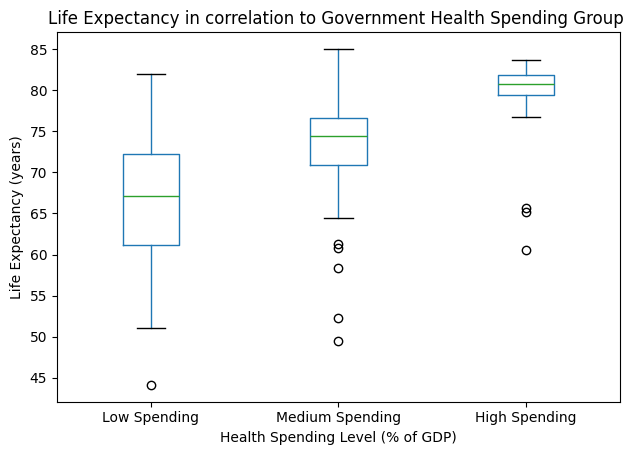

In [ ]:
# Q5: Life Expectancy by Health Spending Group
# ---------------------------------------------
HEALTH_SPEND_IND = "SH.XPD.GHED.GD.ZS"   # Government health spending (% of GDP)
LIFE_EXP_IND    = "SP.DYN.LE00.IN"       # Life expectancy at birth (years)

#Getting Government health spending data
health_df = wb.data.DataFrame(
    [HEALTH_SPEND_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,    # Get country-level only
    skipBlanks=True,
    columns="series"
).reset_index()

# Getting life expectancy data
life_df = wb.data.DataFrame(
    [LIFE_EXP_IND],
    time=YEARS,
    labels=True,
    skipAggs=True,
    skipBlanks=True,
    columns="series"
).reset_index()

#Merge both datasets by country and year, add metadata, and clean by dropping
health_life_clean = (
    health_df.merge(
        life_df[["economy", "Time", LIFE_EXP_IND]],
        on=["economy", "Time"],
        how="inner"
    )
    .merge(
        economies_meta[["economy", "name", "region", "incomeLevel"]],
        on="economy",
        how="left"
    )
    .dropna(subset=[HEALTH_SPEND_IND, LIFE_EXP_IND])
)

#Country-level averages for health spending and life expectancy
country_health_life = (
    health_life_clean
    .groupby(["economy", "name", "region", "incomeLevel"])[[HEALTH_SPEND_IND, LIFE_EXP_IND]]
    .mean()
    .reset_index()
    .rename(columns={
        HEALTH_SPEND_IND: "avg_health_spending_pct",
        LIFE_EXP_IND: "avg_life_expectancy"
    })
)

# Making spending group thresholds by percentages (Low to high)
bins = [0, 3, 6, 15]   # % of GDP: 0–3, 3–6, 6–15
labels = ["Low Spending", "Medium Spending", "High Spending"]

country_health_life["spending_group"] = pd.cut(
    country_health_life["avg_health_spending_pct"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Keeping only rows with a valid group and life expectancy value
plot_data = country_health_life.dropna(subset=["spending_group", "avg_life_expectancy"])

# putting all values together into a box plot
plt.figure(figsize=(10, 6))
plot_data.boxplot(
    column="avg_life_expectancy",
    by="spending_group",
    grid=False
)

plt.title("Life Expectancy in correlation to Government Health Spending Group ")
plt.suptitle("")  # since we made our own title
plt.xlabel("Health Spending Level (% of GDP)")
plt.ylabel("Life Expectancy (years)")
plt.tight_layout()
plt.show()